In [1]:
from os import listdir, makedirs
from os.path import exists, join

import cv2
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from rich.progress import Progress
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_fscore_support, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18

In [2]:
class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        cls = {
            "COVID": 0,
            "Lung_Opacity": 1,
            "Normal": 2,
            "Viral Pneumonia": 3,
        }
        
        classes = listdir(data_dir)
        self.images = []
        self.labels = []
        self.paths = []
        for class_name in classes:
            for image_name in listdir(f"{data_dir}/{class_name}"):
                self.images.append(f"{image_name}")
                self.labels.append(cls[class_name])
                self.paths.append(f"{data_dir}/{class_name}")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = plt.imread(f"{join(self.paths[idx], self.images[idx])}")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, self.images[idx]


def get_transforms():
    return v2.Compose([
        v2.ToImage(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
    ])

def get_data_loader(data_dir, batch_size):
    # dataset = ImageFolder(data_dir, transform=get_transforms())
    dataset = TestDataset(data_dir, transform=get_transforms())
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_device():
    # return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device("cpu")

def load_model(model, model_path):
    device = get_device()
    try:
        model.load_state_dict(torch.load(model_path, map_location=device)["model"])
    except:
        model.load_state_dict(torch.load(model_path, map_location=device)["state_dict"])
    return model

In [3]:
# def predict(model, data_loader):
#     device = get_device()
#     model.to(device)
#     model.eval()

#     # predictions = []
#     predictions = {"pred": [], "label": [], "img": []}
#     with Progress() as progress:
#         task = progress.add_task("[red]Predicting...", total=len(data_loader))
#         for batch in data_loader:
#             x, label, img = batch
#             x = x.to(device)
#             with torch.no_grad():
#                 y = model(x)
#                 res = torch.argmax(y, dim=1)
#                 # predictions.append([res.cpu().numpy()[0], label.numpy()[0]])
#                 predictions["pred"].append(res.cpu().numpy()[0])
#                 predictions["label"].append(label.numpy()[0])
#                 predictions["img"].append(img[0])
#             progress.advance(task)
#     return predictions


def predict(onnx_model, data_loader):
    # predictions = []
    predictions = {"pred": [], "label": [], "img": []}
    with Progress() as progress:
        task = progress.add_task("[red]Predicting...", total=len(data_loader))
        for batch in data_loader:
            x, label, img = batch
            # x = x.to(device)
            # with torch.no_grad():
            #     y = model(x)
            #     res = torch.argmax(y, dim=1)
            #     # predictions.append([res.cpu().numpy()[0], label.numpy()[0]])
            #     predictions["pred"].append(res.cpu().numpy()[0])
            #     predictions["label"].append(label.numpy()[0])
            #     predictions["img"].append(img[0])

            input_name = onnx_model.get_inputs()[0].name
            y = onnx_model.run(None, {input_name: x.numpy()})[0]
            res = np.argmax(y, axis=1)
            predictions["pred"].extend(res)
            predictions["label"].extend(label.numpy())
            predictions["img"].extend(img)
            progress.advance(task)
    return predictions


def confusion_matrix(predictions, classes):
    # matrix = torch.zeros(len(classes), len(classes), dtype=torch.int32)
    matrix = np.zeros((len(classes), len(classes)), dtype=np.int32)
    # for pred, label in predictions:
        # for p, l in zip(pred, label):
    for p, l in predictions:
            matrix[l, p] += 1

    df = pd.DataFrame(matrix, index=classes.keys(), columns=classes.keys())
    return df

def accuracy(confusion_matrix: pd.DataFrame):
    """
    Compute the overall accuracy and per-class accuracy from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class accuracies, mean is the overall accuracy, and std is the standard deviation of the overall accuracy.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Overall accuracy
    correct_predictions = confusion_matrix.values.diagonal().sum()
    total_predictions = confusion_matrix.values.sum()
    
    mean = np.round(correct_predictions / total_predictions if total_predictions > 0 else 0.0, 3)
    std = np.round(np.std(np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)), 3)
    
    return mean, std


# def sensitivity(confusion_matrix: pd.DataFrame):
#     cm = confusion_matrix.to_numpy()

#     sen = np.zeros(len(cm))
#     for i in range(len(cm)):
#         # sen[i] = cm[i, i] / cm[i, :].sum()
#         tp = cm[i, i]
#         fn = cm[i, :].sum() - tp
#         sen[i] = tp / (tp + fn)
#     mean = sen.mean()
#     std = sen.std()
#     sen = np.round(sen, 3)

#     return sen, mean, std

def sensitivity(confusion_matrix: pd.DataFrame):
    """
    Compute the overall sensitivity and per-class sensitivity from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class sensitivities, mean is the overall sensitivity, and std is the standard deviation of the overall sensitivity.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Overall sensitivity
    true_positives = np.diag(confusion_matrix)
    total_actual_positives = confusion_matrix.values.sum(axis=1)
    
    mean = np.round(np.mean(true_positives / total_actual_positives), 3)
    std = np.round(np.std(true_positives / total_actual_positives), 3)
    
    # Per-class sensitivity
    per_class = np.zeros(len(confusion_matrix))
    for i, label in enumerate(confusion_matrix.index):
        true_positive = confusion_matrix.iat[i, i]
        total_actual = confusion_matrix.loc[label].sum()
        per_class[i] = np.round(true_positive / total_actual if total_actual > 0 else 0.0, 3)
    
    return per_class, mean, std


# def precision(confusion_matrix: pd.DataFrame):
#     cm = confusion_matrix.to_numpy()

#     pre = np.zeros(len(cm))
#     for i in range(len(cm)):
#         pre[i] = cm[i, i] / cm[:, i].sum()
#     mean = pre.mean()
#     std = pre.std()
#     pre = np.round(pre, 3)

#     return pre, mean, std

def precision(confusion_matrix: pd.DataFrame):
    """
    Compute the overall precision and per-class precision from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class precisions, mean is the overall precision, and std is the standard deviation of the overall precision.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Overall precision
    true_positives = np.diag(confusion_matrix)
    total_predicted_positives = confusion_matrix.values.sum(axis=0)
    
    mean = np.round(np.mean(true_positives / total_predicted_positives), 3)
    std = np.round(np.std(true_positives / total_predicted_positives), 3)
    
    # Per-class precision
    per_class = np.zeros(len(confusion_matrix))
    for i, label in enumerate(confusion_matrix.index):
        true_positive = confusion_matrix.iat[i, i]
        total_predicted = confusion_matrix.iloc[:, i].sum()
        per_class[i] = np.round(true_positive / total_predicted if total_predicted > 0 else 0.0, 3)
    
    return per_class, mean, std


# def f1_scores(confusion_matrix: pd.DataFrame):
#     cm = confusion_matrix.to_numpy()
    
#     num_classes = len(cm)
#     f1 = np.zeros(num_classes)
    
#     for i in range(num_classes):
#         tp = cm[i, i]
#         fp = cm[:, i].sum() - tp
#         fn = cm[i, :].sum() - tp
        
#         precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#         recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        
#         f1[i] = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
#     mean_f1 = f1.mean()
#     std_f1 = f1.std()
#     f1 = np.round(f1, 3)
    
#     return f1, mean_f1, std_f1

def f1_score(confusion_matrix: pd.DataFrame):
    """
    Compute the overall F1 score and per-class F1 score from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class F1 scores, mean is the overall F1 score, and std is the standard deviation of the overall F1 score.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Compute precision and recall
    def precision_recall(confusion_matrix):
        true_positives = np.diag(confusion_matrix)
        total_predicted_positives = confusion_matrix.values.sum(axis=0)
        precision = true_positives / total_predicted_positives
        total_actual_positives = confusion_matrix.values.sum(axis=1)
        recall = true_positives / total_actual_positives
        return precision, recall
    
    precision_values, recall_values = precision_recall(confusion_matrix)
    
    # Compute F1 score
    f1_scores = 2 * (precision_values * recall_values) / (precision_values + recall_values)
    
    # Overall F1 score
    mean = np.round(np.mean(f1_scores), 3)
    std = np.round(np.std(f1_scores), 3)
    
    # Per-class F1 score
    per_class = np.zeros(len(confusion_matrix))
    for i, label in enumerate(confusion_matrix.index):
        per_class[i] = np.round(f1_scores[i], 3)
    
    return per_class, mean, std


def boxplot(data, title, ylabel, filename):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.savefig(filename)
    plt.show()

In [4]:
class LitCNN2d(pl.LightningModule):
    def __init__(
        self,
        input_shape: int,
        n_classes: int,
        lr: float,
        _logging: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.lr = lr
        self._logging = _logging
        
        self.model = ResNet18(in_channels=input_shape, n_classes=self.n_classes)
        # self.model = AlexNet(in_channels=input_shape, n_classes=n_classes)

    def forward(self, images):
        return self.model(images)

class CNN(nn.Module):
    def __init__(self, in_channels=3, in_features=8, depth=4, n_classes=10):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = nn.ReLU()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc1 = nn.Linear(64 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_block(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

class ResNet18(nn.Module):
    def __init__(self, in_channels=3, in_features=16, n_classes=10):
        super(ResNet18, self).__init__()

        self.model = resnet18()

        self.model.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        self.model.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x
    

class AlexNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super(AlexNet, self).__init__()

        self.model = alexnet()

        self.model.features[0] = nn.Conv2d(
            in_channels, 64, kernel_size=11, stride=4, padding=2
        )

        self.model.classifier[6] = nn.Linear(4096, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        # return self.softmax(x)
        return x

In [5]:
# # model_path = "models/fl_aug_40/checkpoint.pt"
# # model_path = "models/local_aug_10/resnet18_e9.ckpt"
# # model_path = "models/epoch=39-step=42320.ckpt"
# # model_path = "models/resnet18/local_aug_pre_10/checkpoints/epoch=9-step=10580.ckpt"
# # model_path = "models/resnet18/local_aug_40/checkpoints/epoch=39-step=42320.ckpt"
# # model_path = "models/resnet18/fl_resnet18_4cl_e=40.pt"
# # model_path = "models/cnn/local_aug_40/checkpoints/epoch=39-step=42320.ckpt"
# # model_path = "models/cnn/local_aug_40/checkpoints/4_clients/client_2/last.ckpt"
# # model_path = "models/cnn/fl_aug_20/checkpoint.pt"
# # model_path = "models/cnn/fl/4_clients/aug_40/checkpoint.pt"
# # model_path = "models/cnn/fl/10_clients/aug_40_cluster/checkpoint_e=40_cl=10.pt"
# # model_path = "models/resnet18/model_round_3.pth"
# # model_path = "models/alexnet/centralized/last.ckpt"
# # model_path = "models/alexnet/fl/checkpoint_e=40.pt"
# model_path = "models/alexnet/4_clients/fl_alexnet_4cl_e=40.pt"
# # model = load_model(ResNet18(input_shape=1, n_classes=4, lr=0.001), model_path)
# # model = load_model(ResNet18(in_channels=1, n_classes=4), model_path)
# # model = ResNet18(in_channels=1, n_classes=4)
# # model = LitCNN2d(input_shape=1, n_classes=4, lr=0.001)
# model = LitCNN2d(input_shape=1, n_classes=4, lr=0.001)
# state_dict = torch.load(model_path)
# # model.load_state_dict(state_dict)
# model.load_state_dict(state_dict["model"])

In [9]:
# ONNX model inference
model_name = "resnet18"
num_clients = 8
model_type = 100

# model_path = f"models/{model_name}/{num_clients}_clients/federated_model_{model_type}.onnx"
model_path = f"models/{model_name}/local/local_model_{model_type}.onnx"
model = onnx.load(model_path)
ort_session = ort.InferenceSession(model_path)

In [10]:
# client_id = "8_clients"

# _model_path = f"models/{model_name}/{client_id}/checkpoint.pt"
# _model = LitCNN2d(input_shape=1, n_classes=4, lr=0.001)

# # To ONNX
# _weights = torch.load(_model_path)["model"]
# _model.load_state_dict(_weights)
# _model.eval()

# dummy_input = torch.randn(1, 1, 224, 224)
# torch.onnx.export(_model, dummy_input, f"models/{model_name}/{client_id}/federated_model_100.onnx", verbose=True)

In [11]:
data_loader = get_data_loader("datasets/splitted_dataset/test/", 1)
# predictions = predict(model, data_loader)
predictions = predict(ort_session, data_loader)

Output()

In [12]:
classes = {
    "COVID": 0,
    "Lung_Opacity": 1,
    "Normal": 2,
    "Viral Pneumonia": 3,
}

In [13]:
def gather_errors(predictions):
    errors = {}
    for pred, label, img in zip(predictions["pred"], predictions["label"], predictions["img"]):
        if pred != label:
            # errors.append((pred, label, img))
            errors[img] = (pred, label)
    return errors


def plot_errors(errors, data_dir, classes):
    save_dir = "datasets/error_images/"
    if not exists(save_dir):
        makedirs(save_dir)
    
    inv_classes = {v: k for k, v in classes.items()}
    for img, (pred, label) in errors.items():
        pth = join(data_dir, inv_classes[label], img)
        image = plt.imread(f"{pth}")
        plt.imshow(image, cmap="gray")
        plt.title(f"Predicted: {inv_classes[pred]}, Actual: {inv_classes[label]}")
        # plt.savefig(f"datasets/error_images/{img}")
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        plt.grid(False)
        plt.savefig(f"{join(save_dir, img)}", bbox_inches="tight")

In [14]:
errors = gather_errors(predictions)
# plot_errors(errors, "datasets/splitted_dataset/test/", classes)

In [15]:
preds = np.array([[p, l] for p, l in zip(predictions["pred"], predictions["label"])])
cm = confusion_matrix(preds, classes)

In [16]:
# Save predictions
save_dir = "datasets/output/predictions/"
if not exists(save_dir):
    makedirs(save_dir)
    
preds_df = pd.DataFrame(preds, columns=["pred", "label"])
preds_df.to_csv(f"{save_dir}/{model_path.split('/')[-1].split('.')[0]}.csv", index=False)

In [17]:
# y_true = np.array([predictions[i][1][0] for i in range(len(predictions))])
# y_pred = np.array([predictions[i][0][0] for i in range(len(predictions))])

y_true = np.array([preds[i][1] for i in range(len(preds))])
y_pred = np.array([preds[i][0] for i in range(len(preds))])

In [19]:
classifications = classification_report(y_true, y_pred, target_names=classes.keys(), output_dict=True)

classifications_df = pd.DataFrame(classifications).transpose()
classifications_df

,precision,recall,f1-score,support
COVID,0.972222,0.964187,0.968188,363.000000
Lung_Opacity,0.892437,0.882060,0.887218,602.000000
Normal,0.925388,0.936275,0.930799,1020.000000
Viral Pneumonia,0.969925,0.955556,0.962687,135.000000
accuracy,0.926887,0.926887,0.926887,0.926887
macro avg,0.939993,0.934519,0.937223,2120.000000
weighted avg,0.926886,0.926887,0.926856,2120.000000


In [20]:
# mean_acc, std_acc = accuracy(cm)
mean_acc, std_acc = accuracy(cm)
sen, mean_sen, std_sen = sensitivity(cm)
pre, mean_pre, std_pre = precision(cm)
# dsc, mean_dice, std_dice = dice_score(cm)
f1, mean_f1, std_f1 = f1_score(cm)
print(f"Accuracy: {mean_acc:.3f} ± {std_acc:.2f} - (No per-class accuracy because the calculation of the TN takes into account the number of samples correctly classified of the other classes)")
print(f"Sensitivity: {mean_sen:.3f} ± {std_sen:.2f} - {sen}")
print(f"Precision: {mean_pre:.3f} ± {std_pre:.2f} - {pre}")
print(f"F1 score: {mean_f1:.3f} ± {std_f1:.2f} - {f1}")

Accuracy: 0.927 ± 0.03 - (No per-class accuracy because the calculation of the TN takes into account the number of samples correctly classified of the other classes)
Sensitivity: 0.935 ± 0.03 - [0.964 0.882 0.936 0.956]
Precision: 0.940 ± 0.03 - [0.972 0.892 0.925 0.97 ]
F1 score: 0.937 ± 0.03 - [0.968 0.887 0.931 0.963]


In [51]:
def roc_auc(y_true, y_pred, classes):
    for cls, i in classes.items():
        y_true_class = [1 if y == i else 0 for y in y_true]
        y_pred_class = [1 if y == i else 0 for y in y_pred]
        # roc = RocCurveDisplay.from_predictions(y_true_class, y_pred_class)
        # roc.plot()
        # plt.title(f"ROC curve for {cls}")
        # plt.show()

        roc = RocCurveDisplay.from_predictions(y_true_class, y_pred_class, name=cls, color="darkorange", plot_chance_level=True)
        _ = roc.ax_.set(
            title=f"ROC curve for {cls}",
            xlabel="False Positive Rate",
            ylabel="True Positive Rate"
        )


def boxplot(data: dict, title: str, ylabel: str, filename: str):
    fig, ax = plt.subplots(figsize=(10, 5))
    for metric, (mean, std) in data.items():
        ax.errorbar(metric, mean, yerr=std, fmt="o", capsize=5)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    # plt.savefig(filename)
    plt.show()

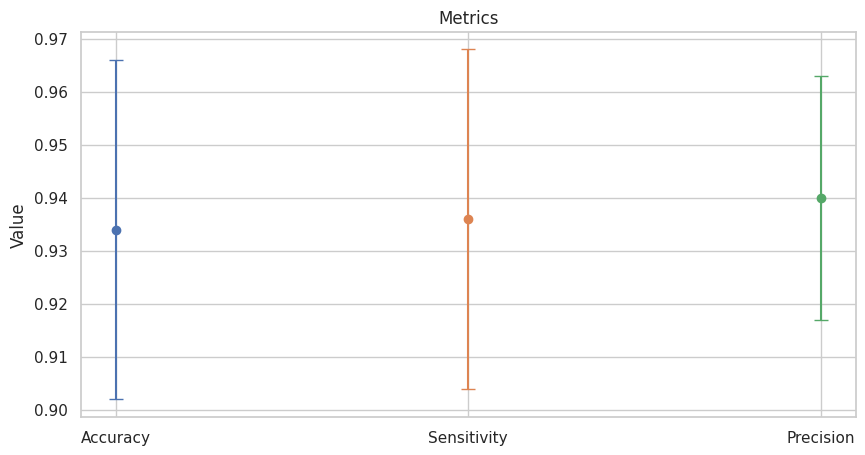

In [52]:
metrics = {
    "Accuracy": (mean_acc, std_acc),
    "Sensitivity": (mean_sen, std_sen),
    "Precision": (mean_pre, std_pre),
}

boxplot(metrics, "Metrics", "Value", "metrics.png")

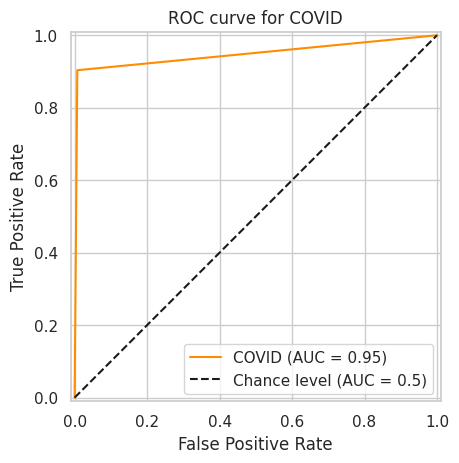

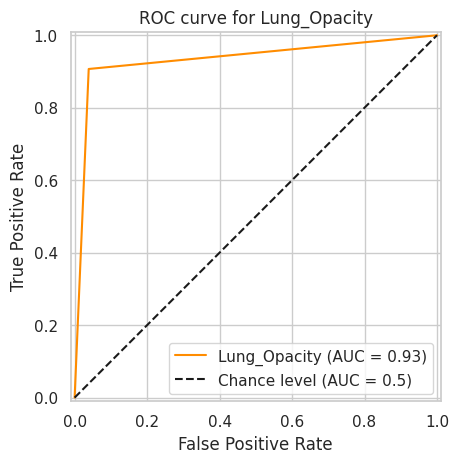

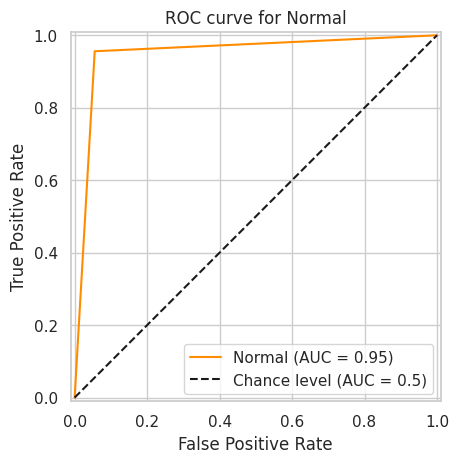

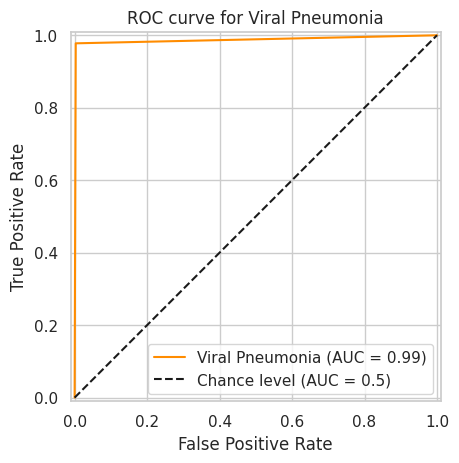

In [53]:
roc_auc(y_true, y_pred, classes)

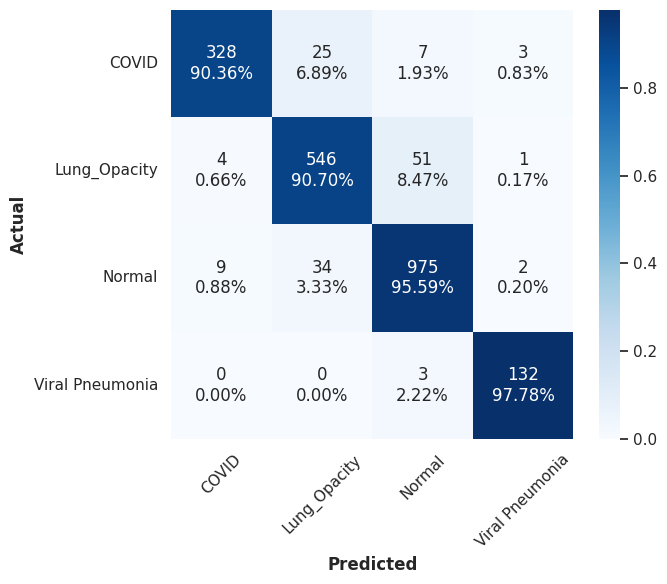

In [54]:
np_cm = cm.to_numpy()
normalized_cm = pd.DataFrame(np_cm / np_cm.sum(axis=1)[:, None], index=classes.keys(), columns=classes.keys())

sns.set(style="whitegrid")

labels = list(classes.keys())
# Take values of the absolute confusion matrix as annotations for the normalized confusion matrix
annotations = cm.to_numpy()
annotations = annotations.astype(str)
for i in range(len(annotations)):
    for j in range(len(annotations)):
        annotations[i, j] = f"{annotations[i, j]}\n{normalized_cm.loc[labels[i], labels[j]] * 100:.2f}%"
# Plot normalized confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(normalized_cm, annot=annotations, fmt="", cmap="Blues")
plt.xlabel("Predicted", fontsize=12, fontweight="bold")
plt.ylabel("Actual", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
# plt.title(f"Normalized Confusion Matrix (centralized learning)", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

In [29]:
curves_dir = join(save_dir, "curves")
res_files = [f for f in listdir(curves_dir) if f.endswith(".csv")]
print(res_files)

['global_acc_fl.csv', 'global_loss_fl.csv', 'mean_client_acc_fl.csv', 'mean_client_loss_fl.csv']


In [ ]:
variables = ["Step", ""]

for file in res_files:
    curves = pd.read_csv(join(curves_dir, file))
    break

In [ ]:
curves.columns

In [ ]:
curves["chest_xray_4_clients_resnet18_cluster - val_accuracy_glob"]

In [ ]:
len(curves["Step"])